<a href="https://colab.research.google.com/github/Rajeeb321123/Latent_sculpting_using_two_stage_method/blob/main/DHS_transformer_encoder_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep

In [ ]:
## SCRIPT 1: preprocess.py (RUN ONCE)
# =================================================================================================
import pandas as pd
import numpy as np
import os
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

print("--- Starting Data Pre-processing Script ---")

# --- 1. Configuration ---
ALL_FILES = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
]

# Using .str.lower() for robust matching
UNSEEN_ATTACK_LABELS = ['dos slowloris', 'dos slowhttptest', 'bot', 'infilteration', 'infiltration']

COLS_TO_DROP_MANUALLY = ['Destination Port']

# Output files
SEEN_DATA_FILE = 'seen_data.feather'
UNSEEN_DATA_FILE = 'unseen_data.feather'
SCALER_FILE = 'scaler_and_cols.joblib'

# --- 2. Batch-loading and Cleaning Loop (RAM-Efficient) ---
seen_attack_dfs = []
unseen_attack_dfs = []
benign_dfs = []

for file_path in ALL_FILES:
    if not os.path.exists(file_path):
        print(f"Warning: File not found, skipping: {file_path}")
        continue

    print(f"Processing file: {file_path}...")
    try:
        df = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
    except Exception as e:
        print(f"Could not read {file_path}: {e}. Skipping.")
        continue

    # --- Cleaning ---
    df.columns = df.columns.str.strip()
    cols_present = [col for col in COLS_TO_DROP_MANUALLY if col in df.columns]
    if cols_present:
        df = df.drop(columns=cols_present)
    df = df.loc[:, ~df.columns.duplicated()]

    label_col = 'Label'
    data_cols = [col for col in df.columns if col != label_col]
    df[data_cols] = df[data_cols].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=[label_col], inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # --- Feature Engineering ---
    if 'Total Length of Fwd Packets' in df.columns and 'Total Fwd Packets' in df.columns:
        df['bytes_per_packet'] = df['Total Length of Fwd Packets'] / (df['Total Fwd Packets'] + 1e-6)
    else:
        df['bytes_per_packet'] = 0

    if 'Total Fwd Packets' in df.columns and 'Flow Duration' in df.columns:
        df['packets_per_second'] = df['Total Fwd Packets'] / (df['Flow Duration'] / 1e6 + 1e-6)
    else:
        df['packets_per_second'] = 0

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # --- Splitting (Batch-wise) ---
    df[label_col] = df[label_col].astype(str).str.strip().str.lower()

    unseen_attack_mask = df[label_col].isin(UNSEEN_ATTACK_LABELS)
    benign_mask = (df[label_col] == 'benign')

    # 1. Unseen attacks
    unseen_attack_dfs.append(df[unseen_attack_mask])
    # 2. Benign traffic
    benign_dfs.append(df[benign_mask])
    # 3. Seen attacks
    seen_attack_dfs.append(df[~unseen_attack_mask & ~benign_mask])

    print(f"Finished processing. Memory before cleanup: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")
    del df; gc.collect()
    print("Memory after cleanup.")

print("\n--- Concatenating all processed data ---")
if not benign_dfs:
    print("Error: No benign data was loaded. Exiting.")
    exit()

# Concatenate all parts
seen_attack_df = pd.concat(seen_attack_dfs, ignore_index=True)
unseen_attack_df = pd.concat(unseen_attack_dfs, ignore_index=True)
benign_df = pd.concat(benign_dfs, ignore_index=True)

del seen_attack_dfs, unseen_attack_dfs, benign_dfs; gc.collect()

print(f"Total seen attacks: {len(seen_attack_df)}")
print(f"Total unseen attacks: {len(unseen_attack_df)}")
print(f"Total benign samples: {len(benign_df)}")

# --- 3. Final Seen/Unseen Split (as per original logic) ---
# Split benign data: 80% for training, 20% for unseen evaluation
benign_seen_df, benign_unseen_df = train_test_split(benign_df, test_size=0.2, random_state=42)

# Final 'seen_df' (for train/eval)
seen_df = pd.concat([seen_attack_df, benign_seen_df], ignore_index=True)
seen_df = seen_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Final 'unseen_eval_df' (for OOD eval)
unseen_eval_df = pd.concat([unseen_attack_df, benign_unseen_df], ignore_index=True)
unseen_eval_df = unseen_eval_df.sample(frac=1, random_state=42).reset_index(drop=True)

del seen_attack_df, unseen_attack_df, benign_df, benign_seen_df, benign_unseen_df; gc.collect()

print(f"\nFinal 'seen_df' (train/eval) shape: {seen_df.shape}")
print(f"Final 'unseen_eval_df' (OOD) shape: {unseen_eval_df.shape}")

# --- 4. Create and Save Scaler ---
print("\n--- Fitting StandardScaler ---")

# Get a temporary training set to fit the scaler and find zero-var columns
y_binary_seen = (seen_df['Label'].str.lower() != 'benign').astype(int)
train_df, _ = train_test_split(seen_df, test_size=0.2, random_state=42, stratify=y_binary_seen)

numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
variances = train_df[numeric_cols].var()
zero_var_cols = variances[variances == 0].index.tolist()

if zero_var_cols:
    print(f"Removing {len(zero_var_cols)} columns with zero variance.")
final_numeric_cols = [col for col in numeric_cols if col not in zero_var_cols]

scaler = StandardScaler()
scaler.fit(train_df[final_numeric_cols].values)
print("Scaler fitted.")

del train_df, y_binary_seen; gc.collect()

# --- 5. Save Artifacts ---
print("\n--- Saving all artifacts ---")

# Save scaler and column list together
joblib.dump({
    'scaler': scaler,
    'columns': final_numeric_cols
}, SCALER_FILE)
print(f"Saved scaler and column list to {SCALER_FILE}")

# Save the final DataFrames using Feather (fast and preserves types)
# Note: Feather requires string column names
seen_df.columns = seen_df.columns.astype(str)
unseen_eval_df.columns = unseen_eval_df.columns.astype(str)
final_numeric_cols = [str(c) for c in final_numeric_cols] # Ensure cols are strings

# We only need to save the features and the label
cols_to_save = final_numeric_cols + ['Label']
seen_df[cols_to_save].to_feather(SEEN_DATA_FILE)
print(f"Saved 'seen' data to {SEEN_DATA_FILE}")

unseen_eval_df[cols_to_save].to_feather(UNSEEN_DATA_FILE)
print(f"Saved 'unseen' data to {UNSEEN_DATA_FILE}")

print("\n--- PRE-PROCESSING FINISHED ---")

--- Starting Data Pre-processing Script ---
Processing file: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.15 GB
Memory after cleanup.
Processing file: Friday-WorkingHours-Morning.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.13 GB
Memory after cleanup.
Processing file: Monday-WorkingHours.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.36 GB
Memory after cleanup.
Processing file: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.20 GB
Memory after cleanup.
Processing file: Tuesday-WorkingHours.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.31 GB
Memory after cleanup.
Processing file: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.20 GB
Memory after cleanup.
Processing file: Wednesday-workingHours.pcap_ISCX.csv...
Finished processing. Memory before cleanup: 0.48 GB
Memory aft

# ADAM W

Using device: cuda

Loading pre-processed data...
Loaded scaler and 71 feature columns.
Loaded 'seen_df' shape: (2362826, 72)
Loaded 'unseen_eval_df' shape: (467917, 72)

Balancing internal validation set (1:1)...
Balancing validation set to 108870 benign and 108870 anomaly.

--- Data Distribution Report ---

Training set distribution (before balancing):
benign                        1454781
dos hulk                       184635
portscan                       127394
ddos                           102349
dos goldeneye                    8254
ftp-patator                      6360
ssh-patator                      4747
web attack � brute force         1192
web attack � xss                  520
web attack � sql injection         18
heartbleed                         10
Name: count, dtype: int64

BALANCED Evaluation set distribution:
benign                        108870
dos hulk                       46438
portscan                       31536
ddos                           25678
dos goldeney

Stage 1 - Epoch 1/10: 100%|██████████| 1212/1212 [00:41<00:00, 29.08it/s, loss=0.893, lr=0.0003]



Epoch 1 Train Stats -> Accuracy: 0.9390, Anomaly F1: 0.9571
Epoch 1 Validation Metrics:
  Anomaly -> F1: 0.9224, Recall: 0.9689, Precision: 0.8802
  Benign  -> F1: 0.9142, Recall: 0.8681, Precision: 0.9654
🎉 New best model found! Saving weights from epoch 1


Stage 1 - Epoch 2/10: 100%|██████████| 1212/1212 [00:41<00:00, 29.35it/s, loss=0.124, lr=0.0003]



Epoch 2 Train Stats -> Accuracy: 0.9531, Anomaly F1: 0.9669
Epoch 2 Validation Metrics:
  Anomaly -> F1: 0.9384, Recall: 0.9779, Precision: 0.9019
  Benign  -> F1: 0.9329, Recall: 0.8936, Precision: 0.9759
🎉 New best model found! Saving weights from epoch 2


Stage 1 - Epoch 3/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.63it/s, loss=0.0836, lr=0.0003]



Epoch 3 Train Stats -> Accuracy: 0.9625, Anomaly F1: 0.9738
Epoch 3 Validation Metrics:
  Anomaly -> F1: 0.9461, Recall: 0.9893, Precision: 0.9066
  Benign  -> F1: 0.9410, Recall: 0.8980, Precision: 0.9882
🎉 New best model found! Saving weights from epoch 3


Stage 1 - Epoch 4/10: 100%|██████████| 1212/1212 [00:41<00:00, 29.55it/s, loss=0.0758, lr=0.0003]



Epoch 4 Train Stats -> Accuracy: 0.9630, Anomaly F1: 0.9740
Epoch 4 Validation Metrics:
  Anomaly -> F1: 0.9475, Recall: 0.9884, Precision: 0.9099
  Benign  -> F1: 0.9428, Recall: 0.9021, Precision: 0.9873
🎉 New best model found! Saving weights from epoch 4


Stage 1 - Epoch 5/10: 100%|██████████| 1212/1212 [00:40<00:00, 30.17it/s, loss=0.0702, lr=0.0003]



Epoch 5 Train Stats -> Accuracy: 0.9692, Anomaly F1: 0.9782
Epoch 5 Validation Metrics:
  Anomaly -> F1: 0.9593, Recall: 0.9838, Precision: 0.9360
  Benign  -> F1: 0.9572, Recall: 0.9328, Precision: 0.9829
🎉 New best model found! Saving weights from epoch 5


Stage 1 - Epoch 6/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.80it/s, loss=0.0678, lr=0.0003]



Epoch 6 Train Stats -> Accuracy: 0.9663, Anomaly F1: 0.9760
Epoch 6 Validation Metrics:
  Anomaly -> F1: 0.9587, Recall: 0.9767, Precision: 0.9413
  Benign  -> F1: 0.9571, Recall: 0.9391, Precision: 0.9758


Stage 1 - Epoch 7/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.94it/s, loss=0.0627, lr=0.0003]



Epoch 7 Train Stats -> Accuracy: 0.9715, Anomaly F1: 0.9798
Epoch 7 Validation Metrics:
  Anomaly -> F1: 0.9624, Recall: 0.9845, Precision: 0.9412
  Benign  -> F1: 0.9606, Recall: 0.9385, Precision: 0.9837
🎉 New best model found! Saving weights from epoch 7


Stage 1 - Epoch 8/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.87it/s, loss=0.062, lr=0.0003]



Epoch 8 Train Stats -> Accuracy: 0.9706, Anomaly F1: 0.9792
Epoch 8 Validation Metrics:
  Anomaly -> F1: 0.9613, Recall: 0.9839, Precision: 0.9397
  Benign  -> F1: 0.9594, Recall: 0.9368, Precision: 0.9831


Stage 1 - Epoch 9/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.81it/s, loss=0.0604, lr=0.0003]



Epoch 9 Train Stats -> Accuracy: 0.9728, Anomaly F1: 0.9807
Epoch 9 Validation Metrics:
  Anomaly -> F1: 0.9638, Recall: 0.9856, Precision: 0.9429
  Benign  -> F1: 0.9621, Recall: 0.9403, Precision: 0.9850
🎉 New best model found! Saving weights from epoch 9


Stage 1 - Epoch 10/10: 100%|██████████| 1212/1212 [00:39<00:00, 30.86it/s, loss=0.0601, lr=0.0003]



Epoch 10 Train Stats -> Accuracy: 0.9729, Anomaly F1: 0.9808
Epoch 10 Validation Metrics:
  Anomaly -> F1: 0.9660, Recall: 0.9825, Precision: 0.9501
  Benign  -> F1: 0.9649, Recall: 0.9484, Precision: 0.9818
🎉 New best model found! Saving weights from epoch 10

Loading best Stage 1 model with F1-Score: 0.9660

Encoder training finished.


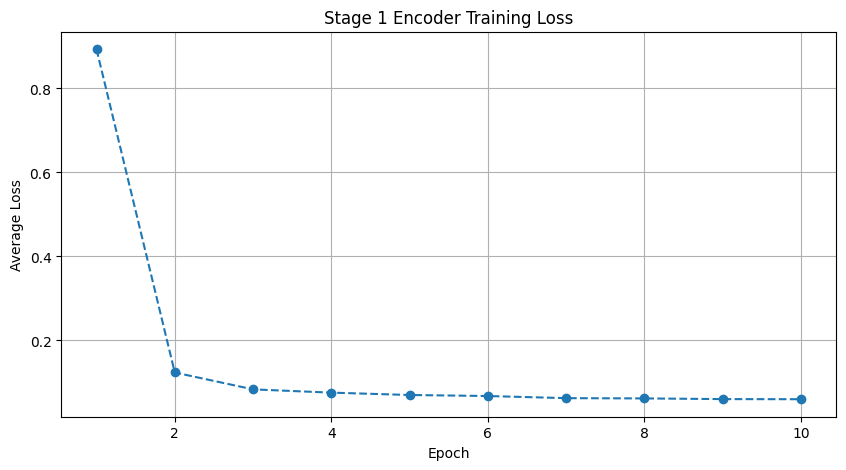

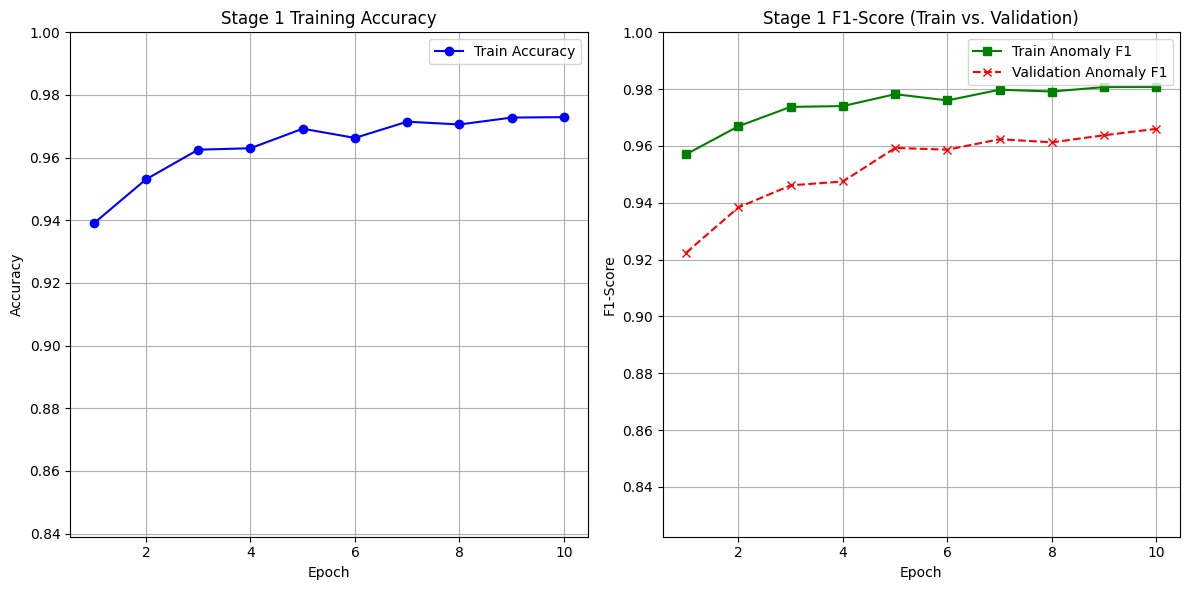


--- Visualizing Latent Space with UMAP ---


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


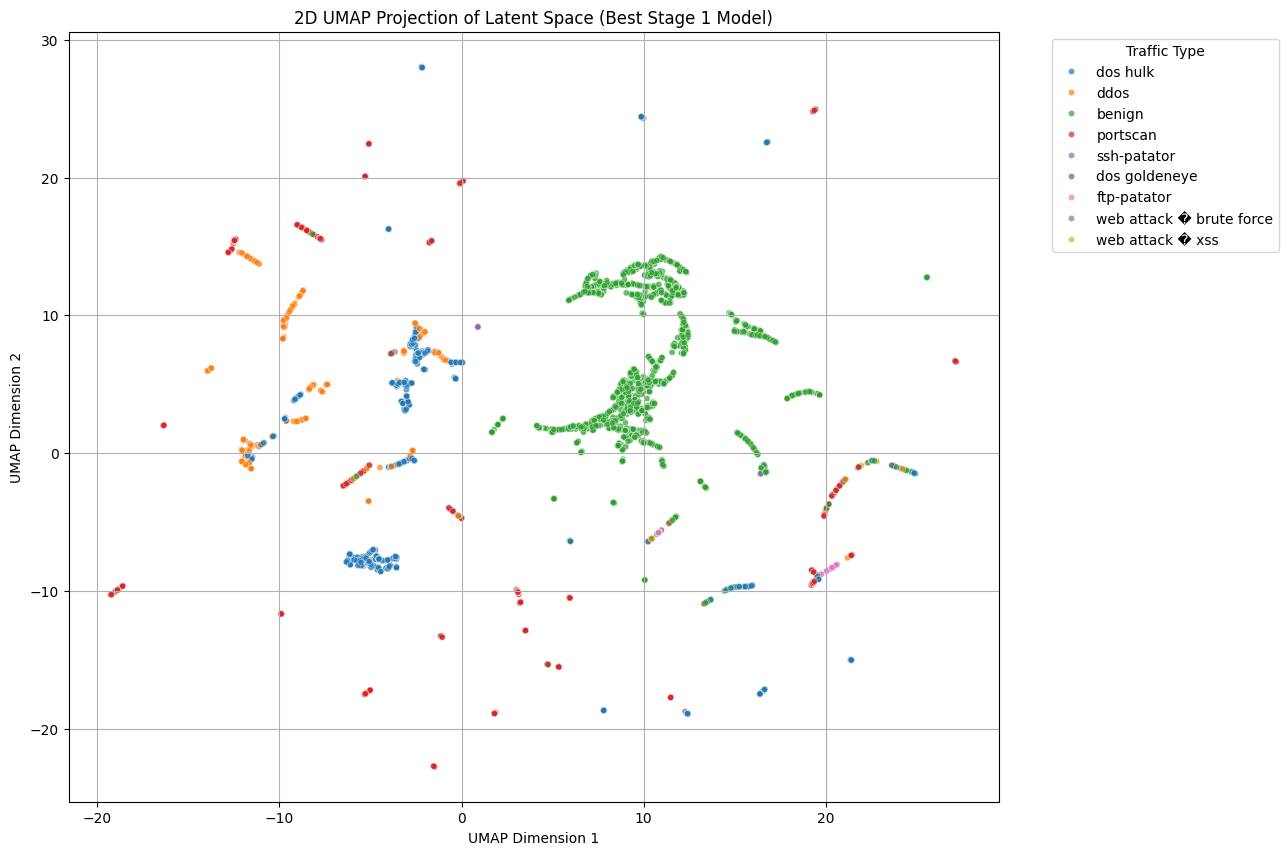


--- Calculating Final Stage 1 Cluster Centers from Best Model ---


Calculating Final Centers: 100%|██████████| 606/606 [00:10<00:00, 59.90it/s]


Benign and anomaly centers calculated and stored.

--- STAGE 2: Training MAF for Expert Review ---
Generating embeddings for benign training data...


Stage 2 (MAF) - Epoch 10/10: 100%|██████████| 2842/2842 [01:09<00:00, 41.11it/s, neg_log_likelihood=-187]


Stage 2 (MAF) training finished.


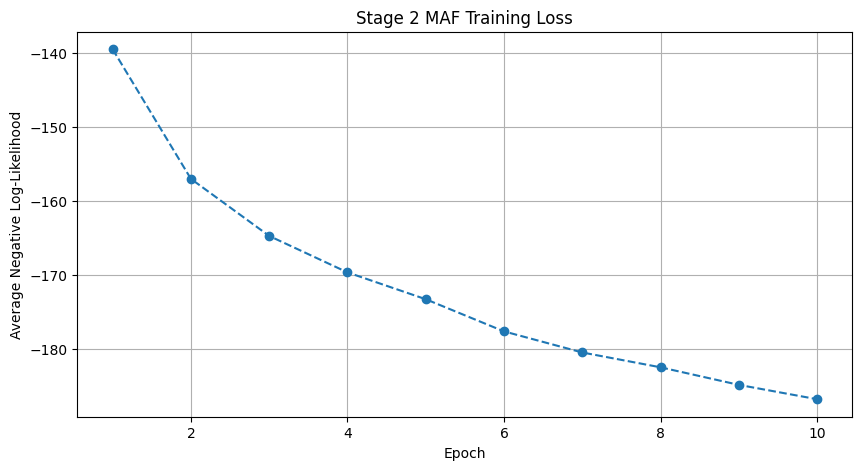


--- Calculating Fixed Stage 2 Anomaly Thresholds (Batch-wise) ---


Scoring Benign Data for Thresholds: 100%|██████████| 2842/2842 [00:21<00:00, 130.76it/s]


✅ Fixed Stage 2 threshold (99th percentile) calculated: -164.221649
✅ Fixed Stage 2 threshold (97th percentile) calculated: -173.086792
✅ Fixed Stage 2 threshold (95th percentile) calculated: -177.197906


============================== RUNNING THRESHOLD SWEEP (Internal Test Set) ==============================

>>> Evaluating Internal Set with 99th Percentile Threshold (-164.221649) <<<

========================= Internal Test Set (P99) =========================
Performing Two-Stage classification (in batches)...


Evaluating Internal Test Set (P99): 100%|██████████| 54/54 [00:25<00:00,  2.14it/s]



--- Intermediate Report: Stage 1 ONLY Performance (Internal Test Set (P99)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96    108870
     Anomaly       0.95      0.98      0.97    108870

    accuracy                           0.97    217740
   macro avg       0.97      0.97      0.97    217740
weighted avg       0.97      0.97      0.97    217740

Stage 1 classified 105167 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -164.221649

--- Final Report: Two-Stage Performance (Internal Test Set (P99)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96    108870
     Anomaly       0.94      0.98      0.96    108870

    accuracy                           0.96    217740
   macro avg       0.96      0.96      0.96    217740
weighted avg       0.96      0.96      0.96    217740


--- Additional Metrics (Internal Test Set (P

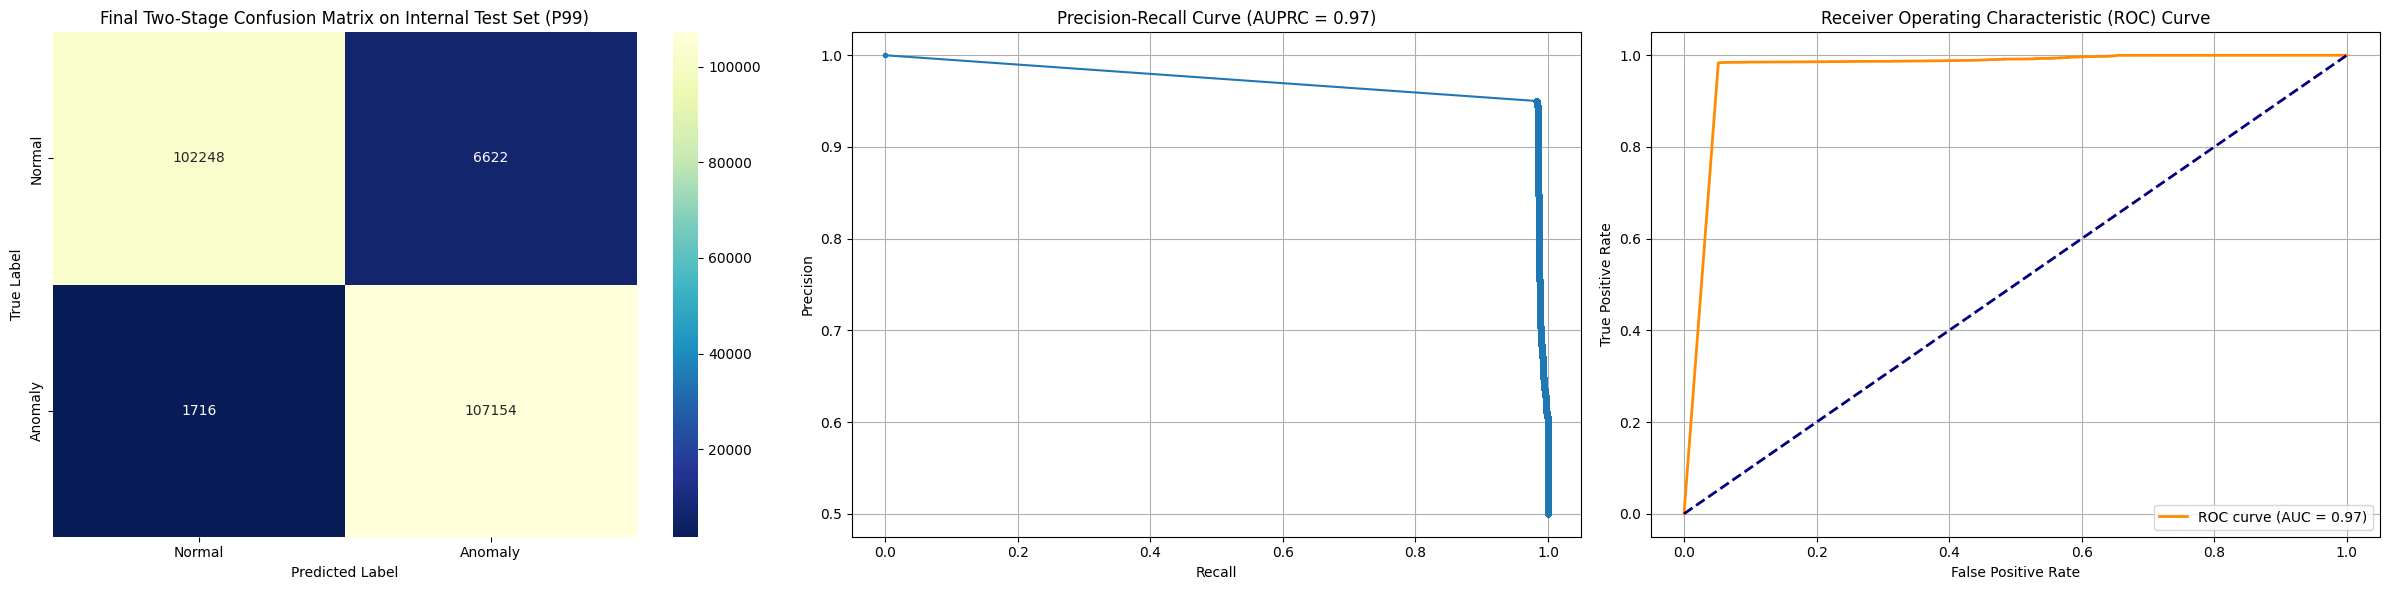


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
ssh-patator                   602
ddos                          416
web attack � brute force      300
web attack � xss              126
dos goldeneye                 119
dos hulk                       90
ftp-patator                    52
portscan                        8
web attack � sql injection      3
Name: count, dtype: int64
-------------------------------------------------------

>>> Evaluating Internal Set with 97th Percentile Threshold (-173.086792) <<<

========================= Internal Test Set (P97) =========================
Performing Two-Stage classification (in batches)...


Evaluating Internal Test Set (P97): 100%|██████████| 54/54 [00:25<00:00,  2.12it/s]



--- Intermediate Report: Stage 1 ONLY Performance (Internal Test Set (P97)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96    108870
     Anomaly       0.95      0.98      0.97    108870

    accuracy                           0.97    217740
   macro avg       0.97      0.97      0.97    217740
weighted avg       0.97      0.97      0.97    217740

Stage 1 classified 105167 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -173.086792

--- Final Report: Two-Stage Performance (Internal Test Set (P97)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95    108870
     Anomaly       0.93      0.98      0.95    108870

    accuracy                           0.95    217740
   macro avg       0.95      0.95      0.95    217740
weighted avg       0.95      0.95      0.95    217740


--- Additional Metrics (Internal Test Set (P

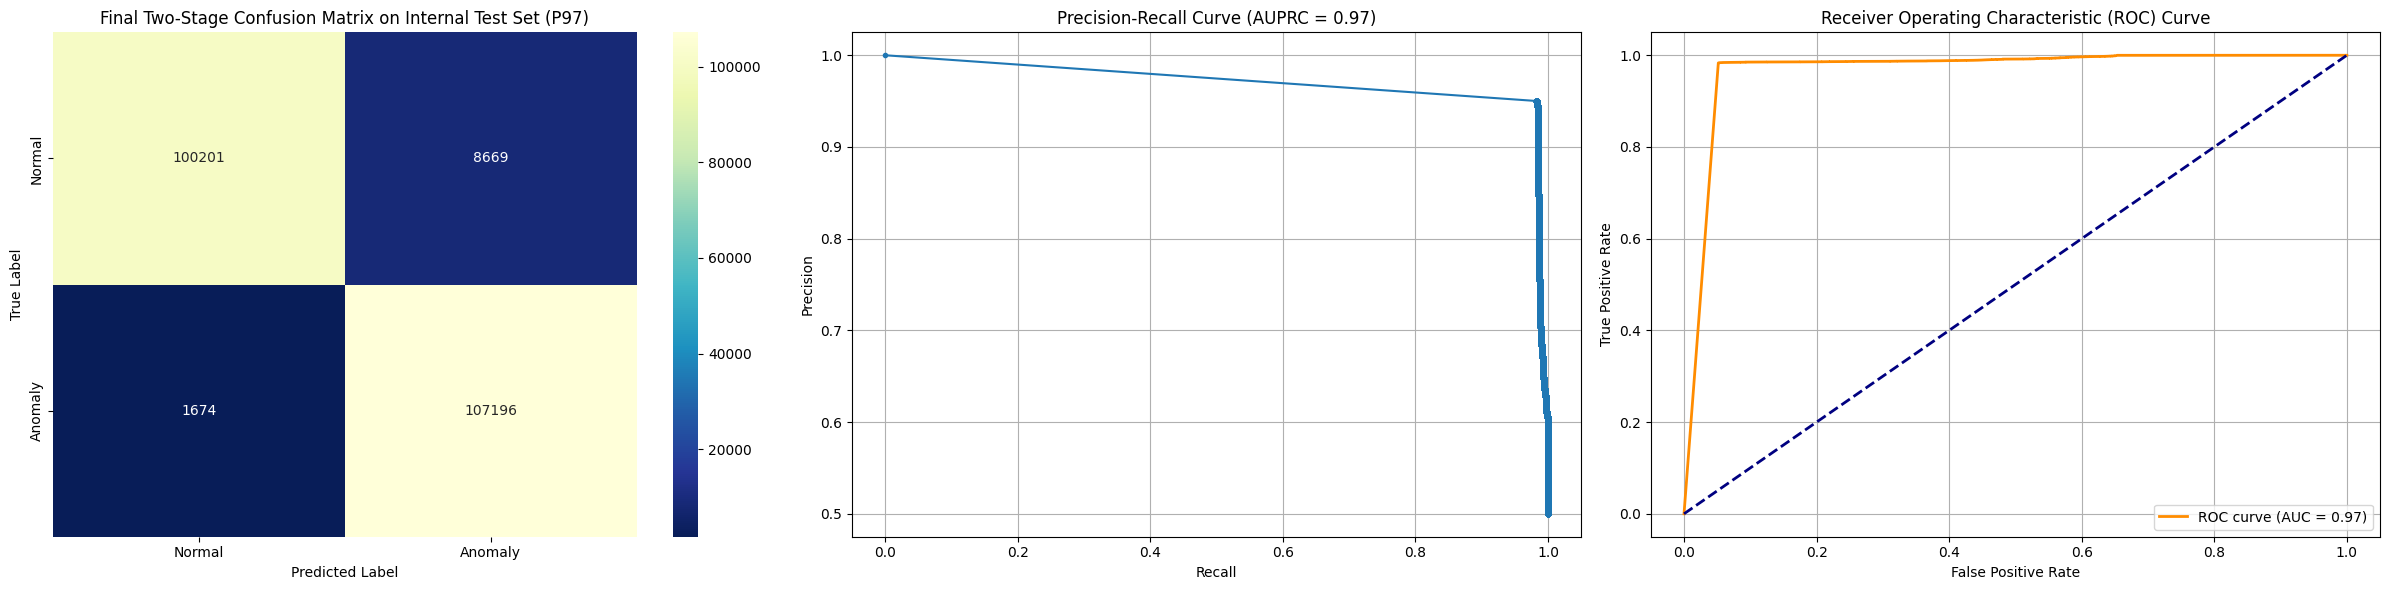


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
ssh-patator                   601
ddos                          406
web attack � brute force      286
web attack � xss              125
dos goldeneye                 119
dos hulk                       88
ftp-patator                    40
portscan                        6
web attack � sql injection      3
Name: count, dtype: int64
-------------------------------------------------------

>>> Evaluating Internal Set with 95th Percentile Threshold (-177.197906) <<<

========================= Internal Test Set (P95) =========================
Performing Two-Stage classification (in batches)...


Evaluating Internal Test Set (P95): 100%|██████████| 54/54 [00:25<00:00,  2.12it/s]



--- Intermediate Report: Stage 1 ONLY Performance (Internal Test Set (P95)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96    108870
     Anomaly       0.95      0.98      0.97    108870

    accuracy                           0.97    217740
   macro avg       0.97      0.97      0.97    217740
weighted avg       0.97      0.97      0.97    217740

Stage 1 classified 105167 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -177.197906

--- Final Report: Two-Stage Performance (Internal Test Set (P95)) ---
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94    108870
     Anomaly       0.91      0.99      0.95    108870

    accuracy                           0.94    217740
   macro avg       0.95      0.94      0.94    217740
weighted avg       0.95      0.94      0.94    217740


--- Additional Metrics (Internal Test Set (P

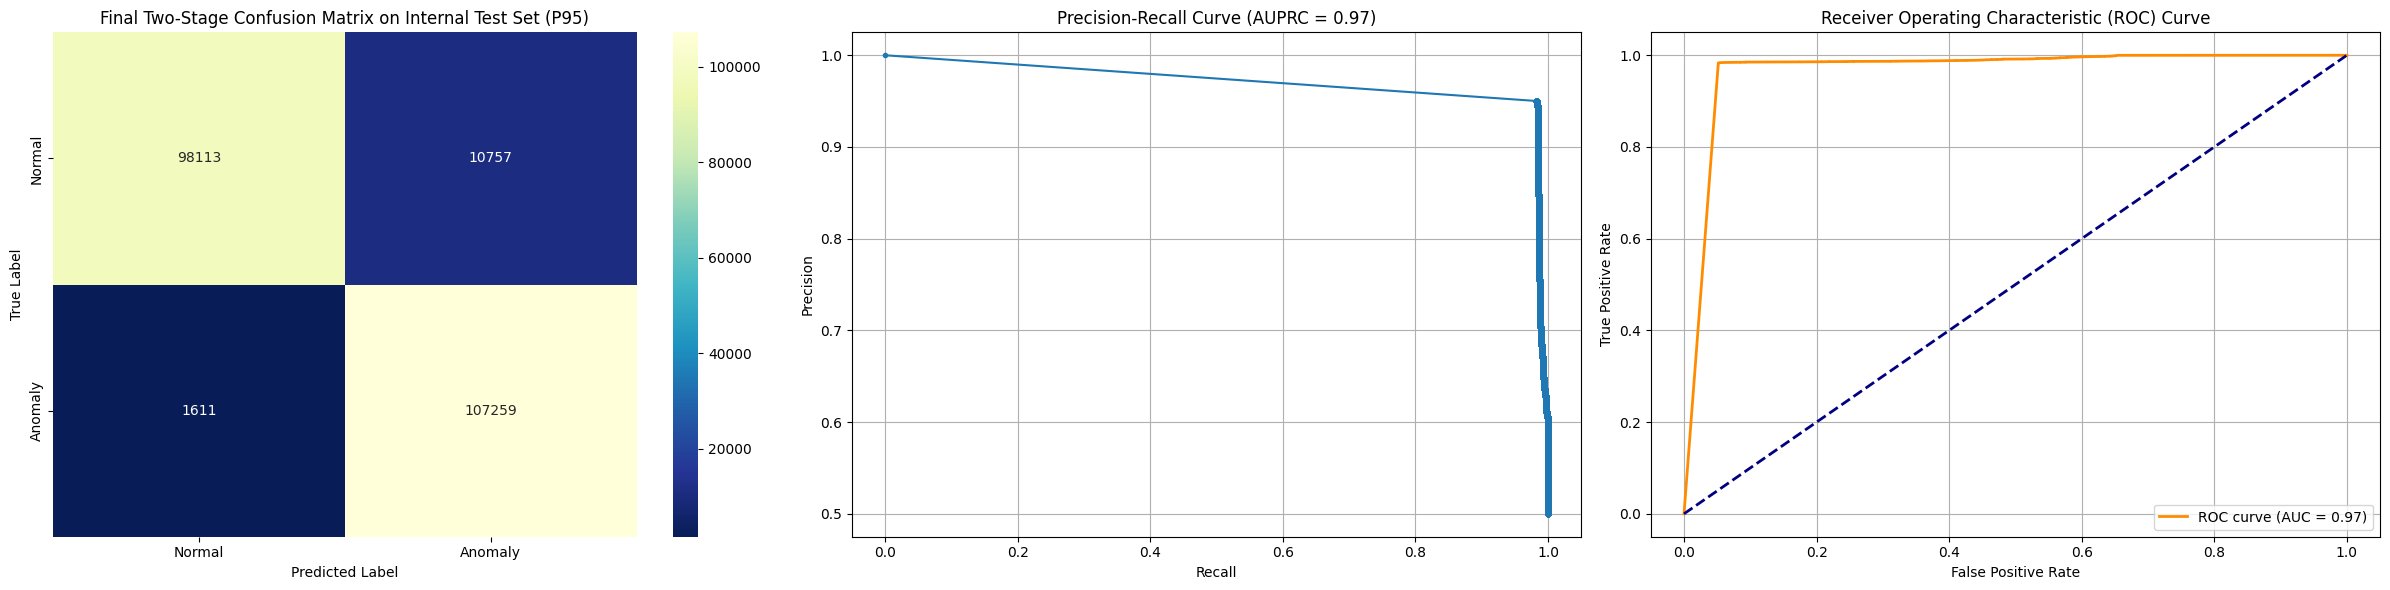


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
ssh-patator                   600
ddos                          402
web attack � brute force      278
web attack � xss              124
dos goldeneye                 113
dos hulk                       86
ftp-patator                     3
web attack � sql injection      3
portscan                        2
Name: count, dtype: int64
-------------------------------------------------------


============================== EVALUATION ON UNSEEN OOD DATA (with Threshold Sweep) ==============================

--- Balancing Unseen OOD Data (1:1) ---
Original unseen counts: 454620 Benign, 13297 Anomaly
Balancing to 13297 samples per class.
Processing 26594 BALANCED unseen samples for final evaluation.
Balanced unseen data distribution:
 benign              13297
dos slowloris        5796
dos slowhttptest     5499
bot                  1966
infiltration           36
N

Evaluating BALANCED Unseen OOD Set (P99): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]



--- Intermediate Report: Stage 1 ONLY Performance (BALANCED Unseen OOD Set (P99)) ---
              precision    recall  f1-score   support

      Normal       0.51      0.95      0.66     13297
     Anomaly       0.62      0.08      0.14     13297

    accuracy                           0.52     26594
   macro avg       0.56      0.52      0.40     26594
weighted avg       0.56      0.52      0.40     26594

Stage 1 classified 24914 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -164.221649

--- Final Report: Two-Stage Performance (BALANCED Unseen OOD Set (P99)) ---
              precision    recall  f1-score   support

      Normal       0.67      0.94      0.78     13297
     Anomaly       0.90      0.54      0.67     13297

    accuracy                           0.74     26594
   macro avg       0.79      0.74      0.73     26594
weighted avg       0.79      0.74      0.73     26594


--- Additional Metrics (BALANCED 

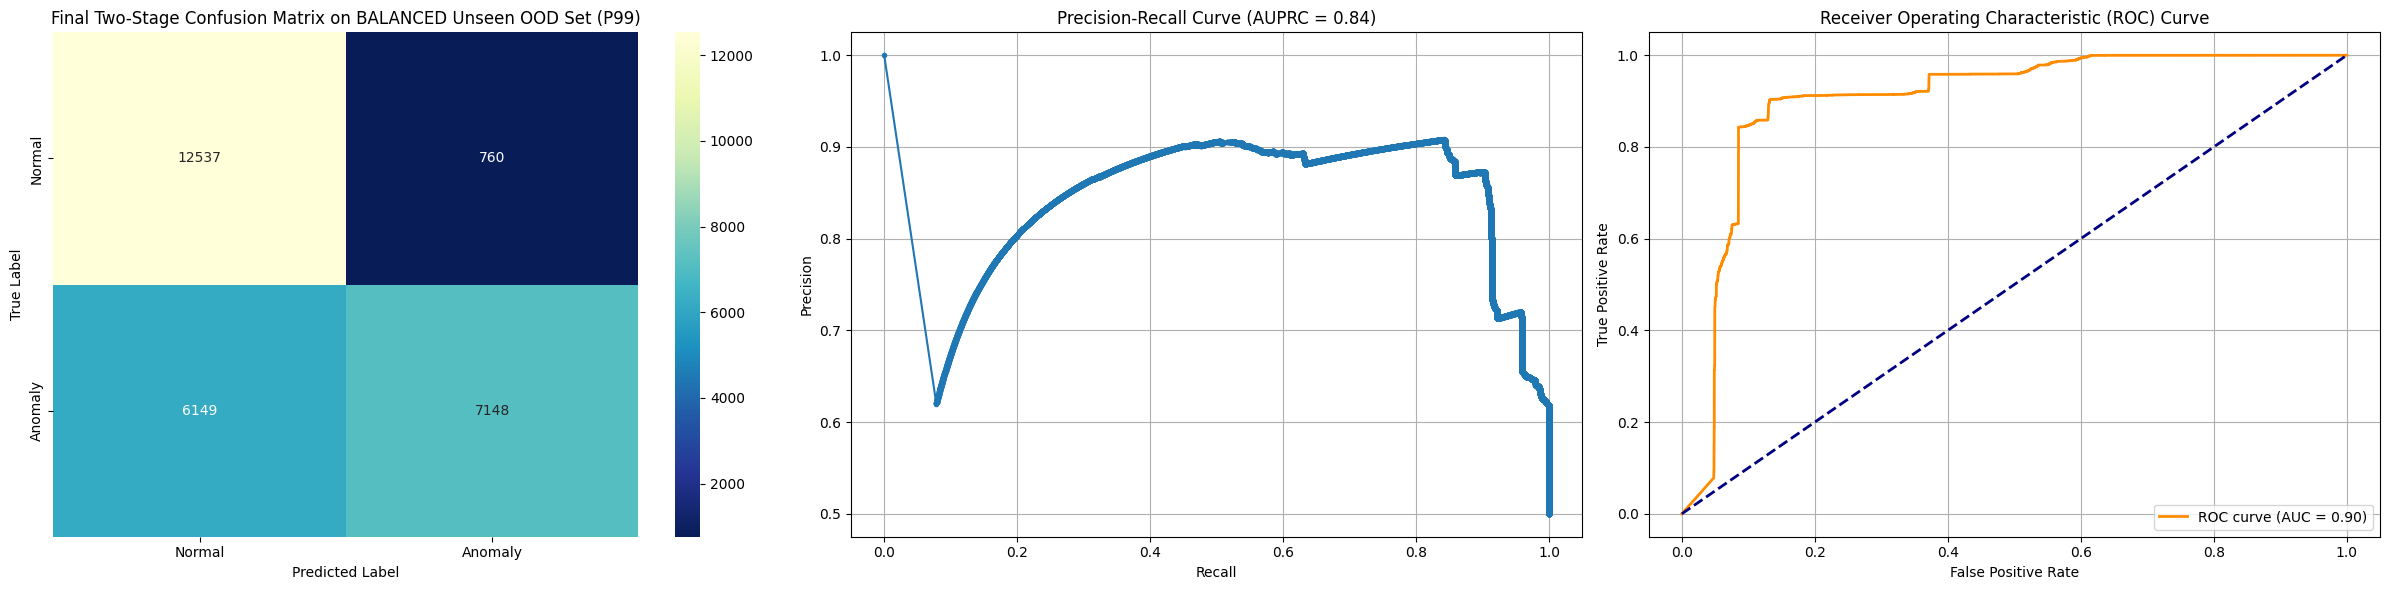


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
dos slowhttptest    3404
bot                 1936
dos slowloris        798
infiltration          11
Name: count, dtype: int64
-------------------------------------------------------

>>> Evaluating BALANCED Unseen OOD Set with 97th Percentile Threshold (-173.086792) <<<

========================= BALANCED Unseen OOD Set (P97) =========================
Performing Two-Stage classification (in batches)...


Evaluating BALANCED Unseen OOD Set (P97): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]



--- Intermediate Report: Stage 1 ONLY Performance (BALANCED Unseen OOD Set (P97)) ---
              precision    recall  f1-score   support

      Normal       0.51      0.95      0.66     13297
     Anomaly       0.62      0.08      0.14     13297

    accuracy                           0.52     26594
   macro avg       0.56      0.52      0.40     26594
weighted avg       0.56      0.52      0.40     26594

Stage 1 classified 24914 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -173.086792

--- Final Report: Two-Stage Performance (BALANCED Unseen OOD Set (P97)) ---
              precision    recall  f1-score   support

      Normal       0.71      0.92      0.80     13297
     Anomaly       0.89      0.63      0.74     13297

    accuracy                           0.78     26594
   macro avg       0.80      0.78      0.77     26594
weighted avg       0.80      0.78      0.77     26594


--- Additional Metrics (BALANCED 

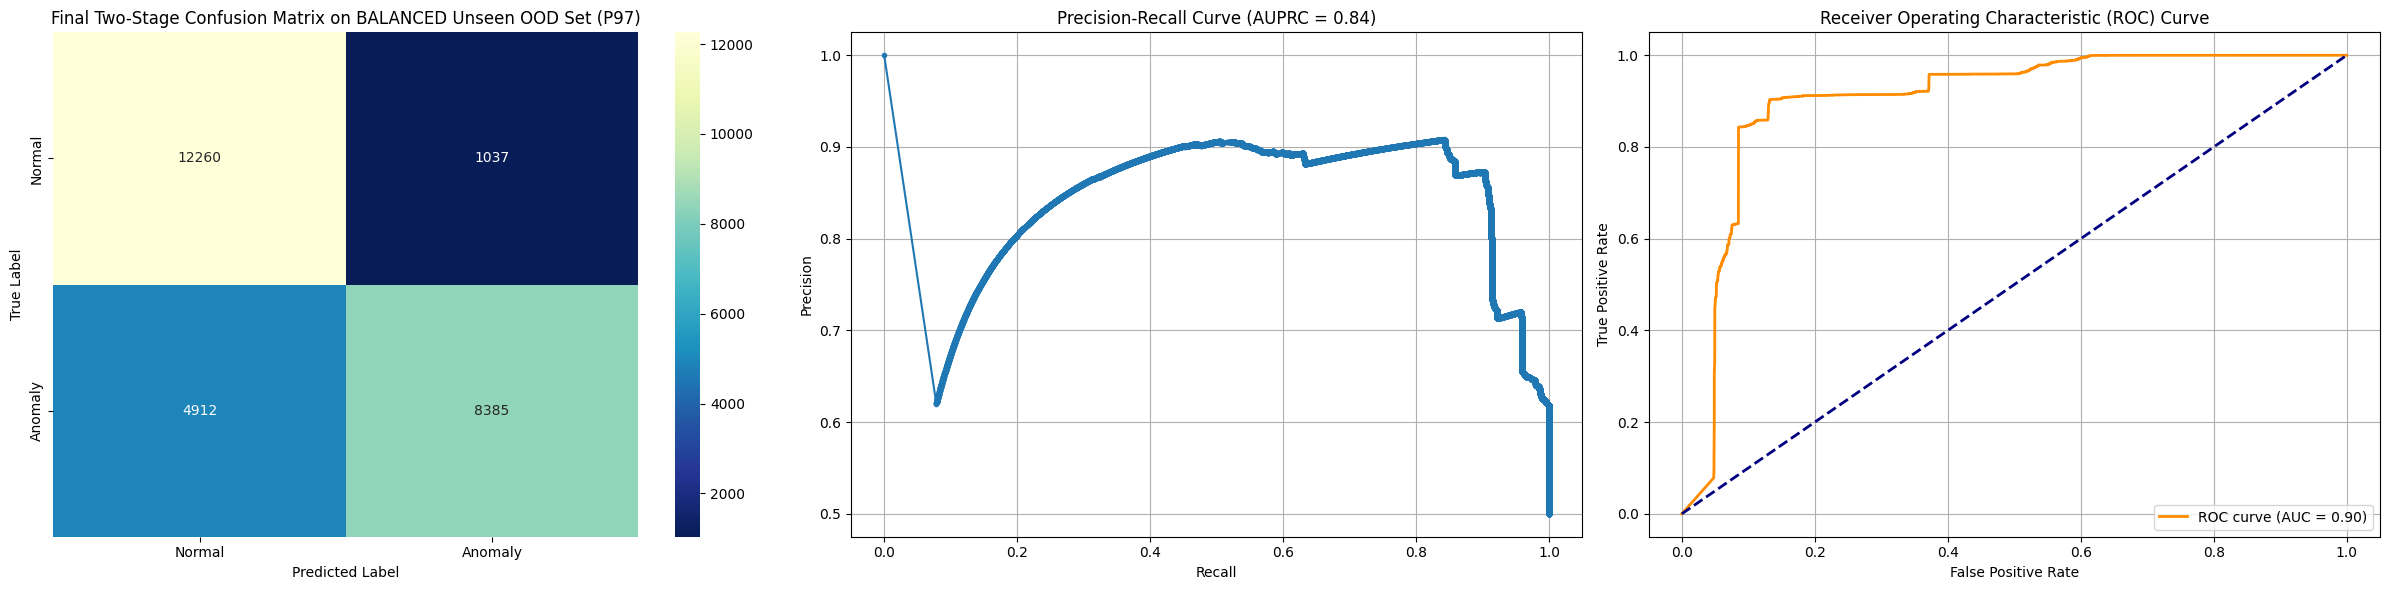


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
dos slowhttptest    2949
bot                 1908
dos slowloris         50
infiltration           5
Name: count, dtype: int64
-------------------------------------------------------

>>> Evaluating BALANCED Unseen OOD Set with 95th Percentile Threshold (-177.197906) <<<

========================= BALANCED Unseen OOD Set (P95) =========================
Performing Two-Stage classification (in batches)...


Evaluating BALANCED Unseen OOD Set (P95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]



--- Intermediate Report: Stage 1 ONLY Performance (BALANCED Unseen OOD Set (P95)) ---
              precision    recall  f1-score   support

      Normal       0.51      0.95      0.66     13297
     Anomaly       0.62      0.08      0.14     13297

    accuracy                           0.52     26594
   macro avg       0.56      0.52      0.40     26594
weighted avg       0.56      0.52      0.40     26594

Stage 1 classified 24914 samples as Normal.
------------------------------------------------------------
Using fixed Stage 2 threshold: -177.197906

--- Final Report: Two-Stage Performance (BALANCED Unseen OOD Set (P95)) ---
              precision    recall  f1-score   support

      Normal       0.85      0.90      0.88     13297
     Anomaly       0.90      0.85      0.87     13297

    accuracy                           0.87     26594
   macro avg       0.87      0.87      0.87     26594
weighted avg       0.87      0.87      0.87     26594


--- Additional Metrics (BALANCED 

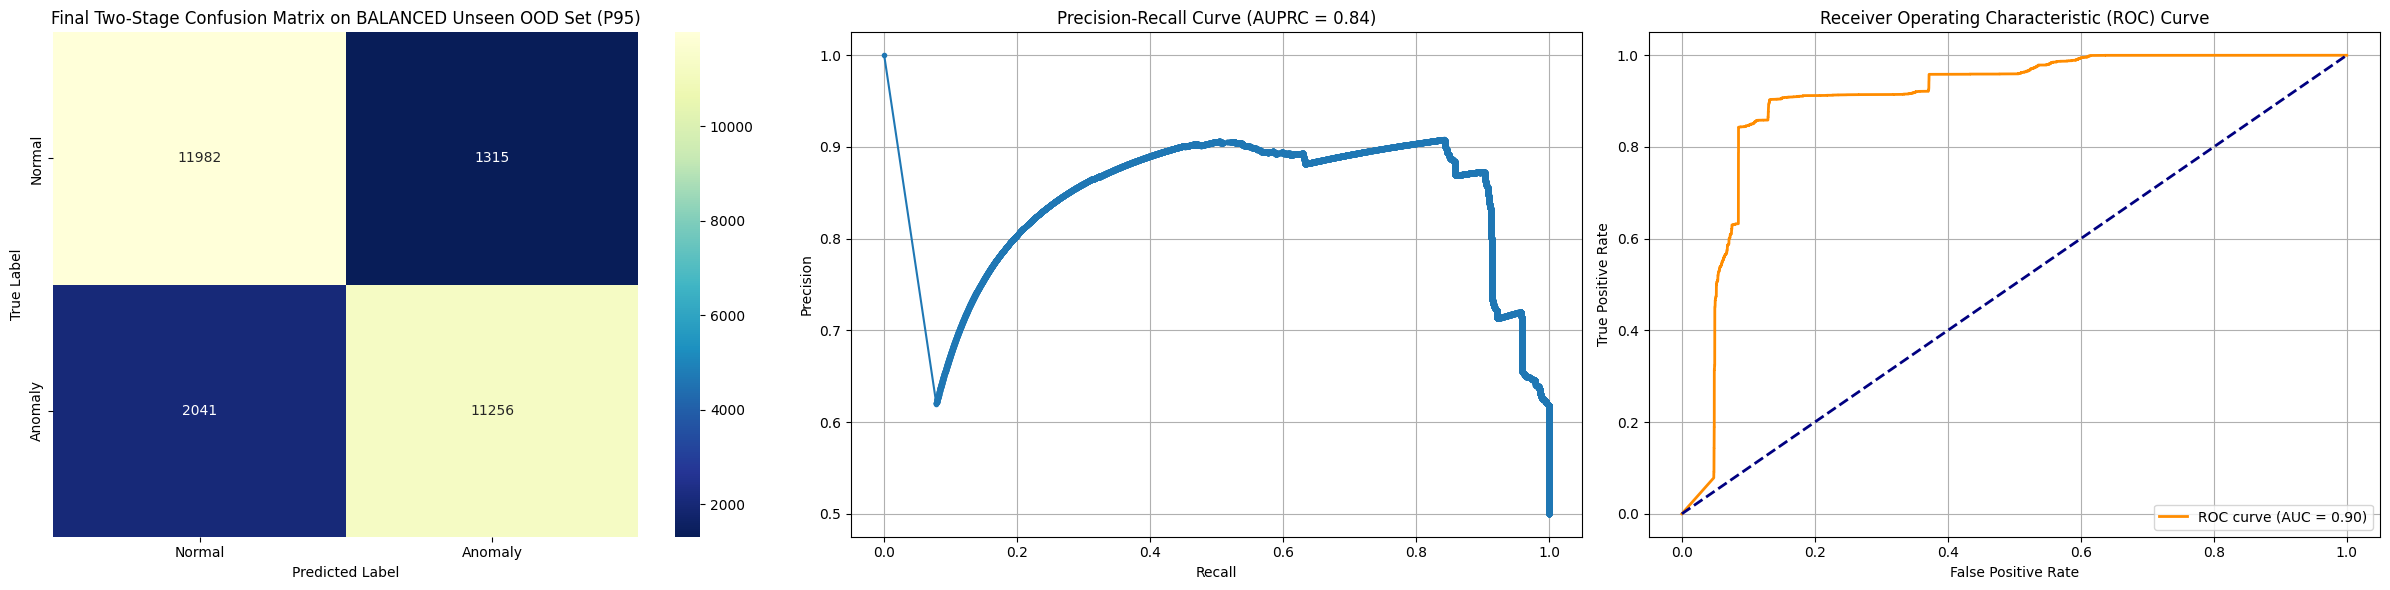


--- Detailed Misclassification Report (False Negatives) ---
The following anomaly types were misclassified as 'Normal':
 true_label
bot                 1886
dos slowhttptest     127
dos slowloris         24
infiltration           4
Name: count, dtype: int64
-------------------------------------------------------

--- SCRIPT FINISHED ---


In [ ]:
## SCRIPT 2: train_and_evaluate.py
# =================================================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import torch.distributions
import umap # For latent space visualization
import copy # For saving the best model state
import gc # For garbage collection to save memory
import joblib # For loading scaler
# import math # No longer needed


## Step 2: Set Up Device (GPU or CPU)
# =================================================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


## Step 3: Load and Prepare the PRE-PROCESSED Data
# =================================================================================================
print("\nLoading pre-processed data...")

SEEN_DATA_FILE = 'seen_data.feather'
UNSEEN_DATA_FILE = 'unseen_data.feather'
SCALER_FILE = 'scaler_and_cols.joblib'

# Check for files
if not all([os.path.exists(f) for f in [SEEN_DATA_FILE, UNSEEN_DATA_FILE, SCALER_FILE]]):
    print("Error: Pre-processed files not found.")
    print("Please run 'preprocess.py' first.")
    exit()

# Load scaler and column list
scaler_data = joblib.load(SCALER_FILE)
scaler = scaler_data['scaler']
final_numeric_cols = scaler_data['columns']
input_dim = len(final_numeric_cols)
print(f"Loaded scaler and {input_dim} feature columns.")

# Load pre-processed dataframes
seen_df = pd.read_feather(SEEN_DATA_FILE)
unseen_eval_df = pd.read_feather(UNSEEN_DATA_FILE)
print(f"Loaded 'seen_df' shape: {seen_df.shape}")
print(f"Loaded 'unseen_eval_df' shape: {unseen_eval_df.shape}")

# --- Data Splitting (from 'seen_df') ---
y_binary_seen = (seen_df['Label'].str.lower() != 'benign').astype(int)
# We need train_df to get anomaly counts
train_df, eval_df = train_test_split(seen_df, test_size=0.2, random_state=42, stratify=y_binary_seen)

# --- Final Data Extraction & Scaling ---
X_train_raw = train_df[final_numeric_cols].values
X_eval_raw = eval_df[final_numeric_cols].values
y_train_binary = (train_df['Label'].str.lower() != 'benign').astype(int).values
y_eval_binary_unbalanced = (eval_df['Label'].str.lower() != 'benign').astype(int).values # Renamed
y_train_str = train_df['Label'].values
y_eval_str_unbalanced = eval_df['Label'].values # Renamed

# Use the loaded scaler
X_train = scaler.transform(X_train_raw)
X_eval_unbalanced = scaler.transform(X_eval_raw) # Renamed

# --- NEW: Balance the Internal Validation Set (X_eval) ---
print("\nBalancing internal validation set (1:1)...")
eval_benign_indices = np.where(y_eval_binary_unbalanced == 0)[0]
eval_anomaly_indices = np.where(y_eval_binary_unbalanced == 1)[0]
n_eval_anomalies = len(eval_anomaly_indices)
n_eval_benign = len(eval_benign_indices)

if n_eval_anomalies > 0 and n_eval_benign > 0:
    n_eval_samples = min(n_eval_anomalies, n_eval_benign)
    print(f"Balancing validation set to {n_eval_samples} benign and {n_eval_samples} anomaly.")

    random_eval_benign_indices = np.random.choice(eval_benign_indices, n_eval_samples, replace=False)
    random_eval_anomaly_indices = np.random.choice(eval_anomaly_indices, n_eval_samples, replace=False)

    balanced_eval_indices = np.concatenate([random_eval_benign_indices, random_eval_anomaly_indices])
    np.random.shuffle(balanced_eval_indices)

    X_eval = X_eval_unbalanced[balanced_eval_indices]
    y_eval_binary = y_eval_binary_unbalanced[balanced_eval_indices]
    y_eval_str = y_eval_str_unbalanced[balanced_eval_indices]

else:
    print("Warning: Validation set has 0 samples of one class. Using unbalanced set.")
    X_eval = X_eval_unbalanced
    y_eval_binary = y_eval_binary_unbalanced
    y_eval_str = y_eval_str_unbalanced
# --- END NEW VALIDATION BALANCING ---


# --- MODIFIED: Data Balancing (for Stage 1 Training) ---
print("\n--- Data Distribution Report ---")
print("\nTraining set distribution (before balancing):"); print(pd.Series(y_train_str).value_counts())
print("\nBALANCED Evaluation set distribution:"); print(pd.Series(y_eval_str).value_counts())
print("-" * 30)

benign_indices = np.where(y_train_binary == 0)[0]
anomaly_indices = np.where(y_train_binary == 1)[0]

# --- *** NEW BALANCING LOGIC AS REQUESTED *** ---
print("\n--- Data Balancing (for Stage 1 Training) ---")
# Get counts of each anomaly type from the original training dataframe
anomaly_counts = train_df[train_df['Label'].str.lower() != 'benign']['Label'].value_counts()
n_anomalies_total = len(anomaly_indices) # Total number of all anomalies

if n_anomalies_total > 0:
    # Find the count of the single most frequent anomaly
    max_anomaly_count = anomaly_counts.max()
    most_frequent_anomaly_name = anomaly_counts.idxmax()

    print(f"Most frequent anomaly: '{most_frequent_anomaly_name}' with {max_anomaly_count} samples.")

    # Set the number of benign samples to match this max count
    n_benign_samples = min(max_anomaly_count, len(benign_indices))

    print(f"Balancing Stage 1 training set:")
    print(f"  Benign: {n_benign_samples} samples (matched to highest anomaly)")
    print(f"  Anomaly: {n_anomalies_total} samples (all types included)")

    random_benign_indices = np.random.choice(benign_indices, n_benign_samples, replace=False)

    balanced_indices = np.concatenate([random_benign_indices, anomaly_indices])
    np.random.shuffle(balanced_indices)

    X_train_stage1 = X_train[balanced_indices]
    y_train_stage1 = y_train_binary[balanced_indices]

    print(f"\nFinal Stage 1 training set size: {len(X_train_stage1)}.")
    print(f" (Benign: {n_benign_samples}, Anomaly: {n_anomalies_total})")
else:
    print("No anomalies found in training data. Stage 1 training set will be empty.")
    X_train_stage1 = np.array([]).reshape(0, X_train.shape[1])
    y_train_stage1 = np.array([])
# --- *** END NEW BALANCING LOGIC *** ---

print(f"Internal evaluation set size: {len(X_eval)} samples.")

# Clean up memory
del seen_df, train_df, eval_df, X_train_raw, X_eval_raw, y_binary_seen
del X_eval_unbalanced, y_eval_binary_unbalanced, y_eval_str_unbalanced # Clean up unbalanced
# KEEP unseen_eval_df for final evaluation
gc.collect()
print("Cleaned up DataFrames to save RAM.")


## Step 5: Define the Model Architectures
# =================================================================================================
# --- NEW: 1D-CNN + Transformer Hybrid Encoder ---
class CnnTransformerEncoder(nn.Module):
    def __init__(self, input_dim, cnn_out_channels=16,
                 transformer_d_model=64, transformer_nhead=4,
                 transformer_num_layers=1, transformer_dim_feedforward=256,
                 output_dim=32, dropout=0.1):
        """
        A hybrid model that uses the 1D-CNN as a feature extractor and a
        Transformer to process the resulting sequence.
        """
        super(CnnTransformerEncoder, self).__init__()

        # 1. CNN Base (from paper, no flatten)
        self.conv_base = nn.Sequential(
            # Input shape: (batch_size, 1, input_dim)
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2), nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=2), nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=2), nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=2), nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=cnn_out_channels, kernel_size=2), nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # --- Get the CNN output sequence length ---
        with torch.no_grad():
            dummy_x = torch.randn(1, 1, input_dim)
            dummy_out = self.conv_base(dummy_x)
            # dummy_out shape is (batch_size, cnn_out_channels, cnn_seq_len)
            self.cnn_seq_len = dummy_out.shape[2] # e.g., 36

        # 2. Linear projector (to project CNN channels to transformer d_model)
        self.input_projector = nn.Linear(cnn_out_channels, transformer_d_model)

        # 3. Positional Embedding for the CNN output sequence
        self.pos_embedding = nn.Parameter(torch.randn(1, self.cnn_seq_len, transformer_d_model))

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_d_model,
            nhead=transformer_nhead,
            dim_feedforward=transformer_dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=transformer_num_layers
        )

        # 5. Pooling & MLP Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(transformer_d_model),
            nn.ReLU(),
            nn.Linear(transformer_d_model, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, input_dim)

        # 1. Reshape for CNN
        x = x.unsqueeze(1)
        # x shape: (batch_size, 1, input_dim)

        # 2. Pass through CNN base
        x = self.conv_base(x)
        # x shape: (batch_size, cnn_out_channels, cnn_seq_len) e.g. (B, 16, 36)

        # 3. Permute for Transformer: (B, seq_len, features)
        x = x.permute(0, 2, 1)
        # x shape: (batch_size, cnn_seq_len, cnn_out_channels) e.g. (B, 36, 16)

        # 4. Project to transformer d_model
        x = self.input_projector(x)
        # x shape: (B, 36, d_model)

        # 5. Add positional embedding
        x = x + self.pos_embedding

        # 6. Pass through Transformer
        x = self.transformer_encoder(x)
        # x shape: (B, 36, d_model)

        # 7. Global Average Pooling (take the mean across the sequence)
        x = x.mean(dim=1)
        # x shape: (B, d_model)

        # 8. Pass to final head
        z = self.mlp_head(x)
        # z shape: (B, output_dim)

        return z

# --- Stage 2 Models (Unchanged) ---
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):super().__init__(in_features, out_features, bias);self.register_buffer('mask', torch.ones(out_features, in_features))
    def set_mask(self, mask):self.mask.data.copy_(mask.to(torch.uint8))
    def forward(self, input):return F.linear(input, self.mask * self.weight, self.bias)
class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__();self.input_dim=input_dim;self.hidden_dim=hidden_dim;self.output_dim=output_dim;self.m={};self.m[0]=torch.arange(1,self.input_dim+1)
        for i in range(num_layers):min_val=torch.min(self.m[i]).item()if self.input_dim>1 else 1;self.m[i+1]=torch.randint(min_val,self.input_dim,(self.hidden_dim,)).sort()[0]
        masks=[(self.m[i+1][:,None]>self.m[i][None,:])for i in range(num_layers)];layers=[]
        for i in range(num_layers):in_d,out_d=(self.input_dim if i==0 else self.hidden_dim),self.hidden_dim;layers.append(MaskedLinear(in_d,out_d));layers[i*2].set_mask(masks[i]);layers.append(nn.ReLU())
        self.net=nn.Sequential(*layers);m_out=self.m[0].repeat(self.output_dim);m_last_hidden=self.m[num_layers];final_mask=(m_out[:,None]>=m_last_hidden[None,:]);self.final_layer=MaskedLinear(self.hidden_dim,self.output_dim*self.input_dim);self.final_layer.set_mask(final_mask)
    def forward(self,x):return self.final_layer(self.net(x)).view(-1,self.output_dim,self.input_dim)
class MaskedAutoregressiveFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__();self.layers=nn.ModuleList([MADE(input_dim,hidden_dim,2)for _ in range(n_layers)]);self.register_buffer('base_dist_loc',torch.zeros(input_dim));self.register_buffer('base_dist_scale_tril',torch.eye(input_dim))
    def forward(self,x):
        log_det_sum=torch.zeros(x.shape[0],device=x.device)
        for i,layer in enumerate(self.layers):
            s,t=layer(x).chunk(2,dim=1);s=s.squeeze(1);t=t.squeeze(1);stable_s=torch.tanh(s);x=x*torch.exp(stable_s)+t;log_det_sum+=stable_s.sum(dim=-1)
            if i<len(self.layers)-1:x=x.flip(dims=[1])
        return x,log_det_sum
    def log_prob(self,x):
        z,log_det_sum=self.forward(x);base_dist=torch.distributions.MultivariateNormal(self.base_dist_loc,scale_tril=self.base_dist_scale_tril);return base_dist.log_prob(z)+log_det_sum


## Step 6: Hyperparameter Configuration
# =================================================================================================
# --- General Parameters ---
batch_size = 512
print(f"Model input_dim set to: {input_dim}")

# --- Stage 1 (CNN-Transformer Hybrid) Hyperparameters ---
print("\n--- Applying CNN-Transformer configuration (~54k params) ---")
latent_dim_s1 = 32      # Final latent space output
cnn_out_channels_s1 = 16 # Paper's final conv layer output channels
d_model_s1 = 64         # Transformer hidden dimension
nhead_s1 = 4            # Heads (must divide d_model)
num_layers_s1 = 3       # Number of transformer layers
dim_feedforward_s1 = 256 # Feedforward dim in transformer
dropout_rate_s1 = 0.1   # Standard dropout
# --------------------------------------------------

learning_rate_s1 = 3e-4
num_epochs_s1 = 10
stage1_noise_level = 0.1
weight_decay_s1 = 1e-2
max_grad_norm_s1 = 1.0

# --- Stage 2 (MAF) Hyperparameters ---
# MAF input_dim is now latent_dim_s1 (32)
nf_n_layers_s2 = 16
nf_hidden_dim_s2 = 512
num_epochs_s2 = 10
learning_rate_s2 = 5e-4


## Step 7: Stage 1 - Train the Encoder with Advanced Regularization
# =================================================================================================
print("\n--- STAGE 1: Training and Validating Encoder with Advanced Regularization ---")
class DualCompactnessLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, gamma=1.0, margin=5.0):
        super(DualCompactnessLoss, self).__init__();self.alpha,self.beta,self.gamma,self.margin=alpha,beta,gamma,margin
    def forward(self, z, labels):
        z_benign, z_anomaly = z[labels==0], z[labels==1]
        loss_cb, loss_ca, loss_s = torch.tensor(0.0, device=z.device), torch.tensor(0.0, device=z.device), torch.tensor(0.0, device=z.device)
        if len(z_benign) > 0: c_b = z_benign.mean(dim=0); loss_cb = torch.mean(torch.sum((z_benign - c_b)**2, dim=1))
        if len(z_anomaly) > 0: c_a = z_anomaly.mean(dim=0); loss_ca = torch.mean(torch.sum((z_anomaly - c_a)**2, dim=1))
        if len(z_benign) > 0 and len(z_anomaly) > 0: loss_s = torch.relu(self.margin - torch.sum((c_b - c_a)**2))
        return self.alpha * loss_cb + self.beta * loss_ca + self.gamma * loss_s

# --- MODIFIED: Instantiate CnnTransformerEncoder ---
encoder = CnnTransformerEncoder(
    input_dim=input_dim,
    cnn_out_channels=cnn_out_channels_s1,
    transformer_d_model=d_model_s1,
    transformer_nhead=nhead_s1,
    transformer_num_layers=num_layers_s1,
    transformer_dim_feedforward=dim_feedforward_s1,
    output_dim=latent_dim_s1,
    dropout=dropout_rate_s1
).to(device)
# ------------------------------------------

def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
s1_params = count_parameters(encoder)
print(f"\n--- Stage 1 Model Parameter Count ---")
print(f"CNN-Transformer (Stage 1) Total: {s1_params:,} parameters")
print(f"Target was ~50k. Achieved: {s1_params:,}")
print("-" * 39)

# --- MODIFIED: Use AdamW optimizer ---
print(f"--- Using AdamW Optimizer for Stage 1 ---")
optimizer = optim.AdamW(
    encoder.parameters(),
    lr=learning_rate_s1,
    weight_decay=weight_decay_s1
)
# --------------------------------------

# criterion = DualCompactnessLoss().to(device)
# --- MODIFIED: Weaken compactness, strengthen separation ---
criterion = DualCompactnessLoss(alpha=0.1, beta=0.1, gamma=1.0, margin=5.0).to(device)
# --------------------------------------------------------
if len(y_train_stage1) == 0: print("Error: Stage 1 training set is empty."); exit()
train_dataset = TensorDataset(torch.tensor(X_train_stage1, dtype=torch.float32), torch.tensor(y_train_stage1, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_s1 * len(train_loader))

best_s1_f1_score = 0.0; best_s1_model_state = None; stage1_epoch_losses = []
# --- NEW: Trackers for train metrics ---
stage1_train_f1s = []
stage1_train_recalls = []
stage1_train_accs = []
stage1_val_f1s = [] # Also track val f1 for plotting
# --- END NEW TRACKERS ---


for epoch in range(num_epochs_s1):
    encoder.train(); total_loss = 0
    pbar = tqdm(train_loader, desc=f"Stage 1 - Epoch {epoch+1}/{num_epochs_s1}")
    for (data, labels) in pbar:
        data, labels = data.to(device), labels.to(device)
        if stage1_noise_level > 0: data_noisy = data + (torch.randn_like(data) * stage1_noise_level)
        else: data_noisy = data
        optimizer.zero_grad(); embeddings = encoder(data_noisy); loss = criterion(embeddings, labels)

        if not torch.isnan(loss):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=max_grad_norm_s1)
            optimizer.step(); total_loss += loss.item()

        pbar.set_postfix({'loss': total_loss / (len(pbar)) if len(pbar) > 0 else 0.0, 'lr': scheduler.get_last_lr()[0]})
    scheduler.step(); stage1_epoch_losses.append(total_loss / len(pbar) if len(pbar) > 0 else 0.0)

    # --- Per-Epoch Validation (MODIFIED) ---
    encoder.eval()
    with torch.no_grad():
        temp_train_ds = TensorDataset(torch.tensor(X_train_stage1, dtype=torch.float32))
        temp_train_loader = DataLoader(temp_train_ds, batch_size=batch_size*4, shuffle=False)
        temp_eval_ds = TensorDataset(torch.tensor(X_eval, dtype=torch.float32))
        temp_eval_loader = DataLoader(temp_eval_ds, batch_size=batch_size*4, shuffle=False)

        all_train_embeddings = [encoder(batch_data.to(device)).cpu() for (batch_data,) in temp_train_loader]
        train_embeddings = torch.cat(all_train_embeddings, dim=0).to(device)

        c_b, c_a = None, None
        if (y_train_stage1 == 0).any(): c_b = train_embeddings[y_train_stage1 == 0].mean(dim=0)
        if (y_train_stage1 == 1).any(): c_a = train_embeddings[y_train_stage1 == 1].mean(dim=0)
        if c_b is None: c_b = torch.zeros(latent_dim_s1, device=device)
        if c_a is None: c_a = torch.zeros(latent_dim_s1, device=device)

        # --- NEW: Calculate Stage 1 Training Metrics ---
        dist_to_b_train = torch.sum((train_embeddings - c_b)**2, dim=1)
        dist_to_a_train = torch.sum((train_embeddings - c_a)**2, dim=1)
        y_pred_train = (dist_to_a_train < dist_to_b_train).int().cpu().numpy()

        train_anomaly_f1 = f1_score(y_train_stage1, y_pred_train, pos_label=1, zero_division=0)
        train_anomaly_recall = recall_score(y_train_stage1, y_pred_train, pos_label=1, zero_division=0)
        train_accuracy = (y_pred_train == y_train_stage1).mean()

        print(f"\nEpoch {epoch+1} Train Stats -> Accuracy: {train_accuracy:.4f}, Anomaly F1: {train_anomaly_f1:.4f}")
        stage1_train_f1s.append(train_anomaly_f1)
        stage1_train_recalls.append(train_anomaly_recall)
        stage1_train_accs.append(train_accuracy)
        # --- END NEW METRICS ---

        all_eval_embeddings = [encoder(batch_data.to(device)).cpu() for (batch_data,) in temp_eval_loader]
        eval_embeddings = torch.cat(all_eval_embeddings, dim=0).to(device)
        dist_to_b = torch.sum((eval_embeddings - c_b)**2, dim=1); dist_to_a = torch.sum((eval_embeddings - c_a)**2, dim=1)
        y_pred_eval = (dist_to_a < dist_to_b).int().cpu().numpy()

        # --- MODIFIED: Detailed Validation Metrics ---
        anomaly_f1 = f1_score(y_eval_binary, y_pred_eval, pos_label=1, zero_division=0)
        anomaly_recall = recall_score(y_eval_binary, y_pred_eval, pos_label=1, zero_division=0)
        anomaly_precision = precision_score(y_eval_binary, y_pred_eval, pos_label=1, zero_division=0)

        benign_f1 = f1_score(y_eval_binary, y_pred_eval, pos_label=0, zero_division=0)
        benign_recall = recall_score(y_eval_binary, y_pred_eval, pos_label=0, zero_division=0)
        benign_precision = precision_score(y_eval_binary, y_pred_eval, pos_label=0, zero_division=0)

        print(f"Epoch {epoch+1} Validation Metrics:")
        print(f"  Anomaly -> F1: {anomaly_f1:.4f}, Recall: {anomaly_recall:.4f}, Precision: {anomaly_precision:.4f}")
        print(f"  Benign  -> F1: {benign_f1:.4f}, Recall: {benign_recall:.4f}, Precision: {benign_precision:.4f}")
        # --- END MODIFIED METRICS ---

        stage1_val_f1s.append(anomaly_f1) # Add validation F1 for plotting

        if anomaly_f1 > best_s1_f1_score:
            best_s1_f1_score = anomaly_f1; best_s1_model_state = copy.deepcopy(encoder.state_dict())
            print(f"🎉 New best model found! Saving weights from epoch {epoch+1}")

    del train_embeddings, eval_embeddings, all_train_embeddings, all_eval_embeddings; gc.collect(); torch.cuda.empty_cache()

if best_s1_model_state:
    print(f"\nLoading best Stage 1 model with F1-Score: {best_s1_f1_score:.4f}"); encoder.load_state_dict(best_s1_model_state)
else: print("\nWarning: No best model was saved. Using model from the last epoch.")

print("\nEncoder training finished.")
plt.figure(figsize=(10, 5)); plt.plot(range(1, num_epochs_s1 + 1), stage1_epoch_losses, marker='o', linestyle='--'); plt.title("Stage 1 Encoder Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Average Loss"); plt.grid(True); plt.show()

# --- NEW: Plot for Stage 1 Metrics ---
plt.figure(figsize=(12, 6))
epochs_range = range(1, num_epochs_s1 + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, stage1_train_accs, 'b-', marker='o', label='Train Accuracy')
plt.title('Stage 1 Training Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.ylim(bottom=max(0.0, min(stage1_train_accs, default=0) - 0.1), top=1.0) # Set y-axis limits

plt.subplot(1, 2, 2)
plt.plot(epochs_range, stage1_train_f1s, 'g-', marker='s', label='Train Anomaly F1')
plt.plot(epochs_range, stage1_val_f1s, 'r--', marker='x', label='Validation Anomaly F1')
plt.title('Stage 1 F1-Score (Train vs. Validation)')
plt.xlabel('Epoch'); plt.ylabel('F1-Score'); plt.legend(); plt.grid(True)
plt.ylim(bottom=max(0.0, min(min(stage1_train_f1s, default=0), min(stage1_val_f1s, default=0)) - 0.1), top=1.0) # Set y-axis limits

plt.tight_layout()
plt.show()
# --- END NEW PLOT ---

print("\n--- Visualizing Latent Space with UMAP ---")
encoder.eval(); subset_size = min(5000, len(X_eval))
if subset_size > 0:
    subset_indices = np.random.choice(len(X_eval), subset_size, replace=False); X_eval_subset = X_eval[subset_indices]; y_eval_str_subset = y_eval_str[subset_indices]
    with torch.no_grad(): embeddings_subset = encoder(torch.tensor(X_eval_subset, dtype=torch.float32).to(device)).cpu().numpy()
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42); embedding_2d = reducer.fit_transform(embeddings_subset)
    plt.figure(figsize=(12, 10)); sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=y_eval_str_subset, s=20, alpha=0.7)
    plt.title('2D UMAP Projection of Latent Space (Best Stage 1 Model)'); plt.xlabel('UMAP Dimension 1'); plt.ylabel('UMAP Dimension 2'); plt.legend(title='Traffic Type', bbox_to_anchor=(1.05, 1), loc='upper left'); plt.grid(True); plt.show()
else: print("Skipping UMAP visualization as eval set is too small.")

print("\n--- Calculating Final Stage 1 Cluster Centers from Best Model ---")
center_benign = torch.zeros(latent_dim_s1, device=device); center_anomaly = torch.zeros(latent_dim_s1, device=device)
if len(X_train_stage1) > 0:
    encoder.eval()
    with torch.no_grad():
        temp_train_ds = TensorDataset(torch.tensor(X_train_stage1, dtype=torch.float32)); temp_train_loader = DataLoader(temp_train_ds, batch_size=batch_size*2, shuffle=False)
        all_train_embeddings = []; pbar = tqdm(temp_train_loader, desc="Calculating Final Centers")
        for (batch_data,) in pbar: all_train_embeddings.append(encoder(batch_data.to(device)).cpu())
        train_embeddings = torch.cat(all_train_embeddings, dim=0).to(device)
        if (y_train_stage1 == 0).any(): center_benign = train_embeddings[y_train_stage1 == 0].mean(dim=0)
        if (y_train_stage1 == 1).any(): center_anomaly = train_embeddings[y_train_stage1 == 1].mean(dim=0)
        print("Benign and anomaly centers calculated and stored.")
        del train_embeddings, all_train_embeddings; gc.collect(); torch.cuda.empty_cache()
else: print("Stage 1 training data was empty, using zero vectors for centers.")


## Step 8: Stage 2 - Train a Masked Autoregressive Flow (MAF)
# =================================================================================================
# (MODIFIED to calculate thresholds in batches to save RAM)
print("\n--- STAGE 2: Training MAF for Expert Review ---")
encoder.eval()
print("Generating embeddings for benign training data...")
benign_train_indices = np.where(y_train_binary == 0)[0]

# --- MODIFIED: Threshold sweep 95 and 90 only ---
PERCENTILES_S2 = [99, 97, 95]
# ------------------------------------------------

fixed_s2_thresholds = None
stage2_model = None

if len(benign_train_indices) > 0:
    benign_train_data = torch.tensor(X_train[benign_train_indices], dtype=torch.float32)

    # Loader for generating embeddings for MAF training
    benign_loader_for_training = DataLoader(TensorDataset(benign_train_data), batch_size=batch_size, shuffle=False)
    all_benign_embeddings = []
    with torch.no_grad():
        for (batch,) in tqdm(benign_loader_for_training, desc="Generating Benign Embeddings for MAF"):
            embeddings = encoder(batch.to(device))
            all_benign_embeddings.append(embeddings.cpu())
    benign_embeddings_tensor = torch.cat(all_benign_embeddings, dim=0)
    del all_benign_embeddings; gc.collect() # Clean up

    # --- MODIFIED: MAF input_dim is now latent_dim_s1 (32) ---
    stage2_model = MaskedAutoregressiveFlow(
        input_dim=latent_dim_s1,
        hidden_dim=nf_hidden_dim_s2,
        n_layers=nf_n_layers_s2
    ).to(device)
    # --------------------------------------------------------

    optimizer_s2 = optim.Adam(stage2_model.parameters(), lr=learning_rate_s2)
    nf_loader = DataLoader(TensorDataset(benign_embeddings_tensor), batch_size=batch_size, shuffle=True)
    stage2_epoch_losses = []
    for epoch in range(num_epochs_s2):
        stage2_model.train(); total_loss = 0
        pbar = tqdm(nf_loader, desc=f"Stage 2 (MAF) - Epoch {epoch+1}/{num_epochs_s2}")
        for (data,) in pbar:
            data = data.to(device); optimizer_s2.zero_grad(); log_likelihood = stage2_model.log_prob(data); loss = -torch.mean(log_likelihood)
            if not torch.isnan(loss) and not torch.isinf(loss):
                loss.backward(); torch.nn.utils.clip_grad_norm_(stage2_model.parameters(), 1.0); optimizer_s2.step(); total_loss += loss.item()
            pbar.set_postfix({'neg_log_likelihood': total_loss / (len(pbar) if len(pbar) > 0 else 1.0)})
        stage2_epoch_losses.append(total_loss / (len(pbar) if len(pbar) > 0 else 1.0))

    print("\nStage 2 (MAF) training finished.")
    plt.figure(figsize=(10, 5)); plt.plot(range(1, num_epochs_s2 + 1), stage2_epoch_losses, marker='o', linestyle='--'); plt.title("Stage 2 MAF Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Average Negative Log-Likelihood"); plt.grid(True); plt.show()

    # --- MODIFICATION: Calculate all thresholds IN BATCHES ---
    print("\n--- Calculating Fixed Stage 2 Anomaly Thresholds (Batch-wise) ---")
    stage2_model.eval()

    all_benign_scores = []
    with torch.no_grad():
        # Re-use nf_loader, which has benign_embeddings_tensor, for batching
        for (batch_data,) in tqdm(nf_loader, desc="Scoring Benign Data for Thresholds"):
            batch_data = batch_data.to(device)
            benign_scores_batch = -stage2_model.log_prob(batch_data)
            all_benign_scores.append(benign_scores_batch.cpu().numpy())

    all_benign_scores_np = np.concatenate(all_benign_scores)
    fixed_s2_thresholds = {}

    for p in PERCENTILES_S2:
        threshold_val = np.percentile(all_benign_scores_np, p)
        fixed_s2_thresholds[p] = threshold_val
        print(f"✅ Fixed Stage 2 threshold ({p}th percentile) calculated: {threshold_val:.6f}")

    del benign_embeddings_tensor, all_benign_scores, all_benign_scores_np; gc.collect(); torch.cuda.empty_cache()
else:
    print("Error: No benign data found in training set. Cannot train Stage 2 MAF.")


## Step 9: Final Two-Stage Evaluations (MODIFIED FOR BATCH-WISE INFERENCE + PER-ATTACK ACCURACY)
# =================================================================================================

# --- MODIFIED: RAM-EFFICIENT EVALUATION FUNCTION (WITH AUROC/AUPRC) ---
def evaluate_two_stage(encoder_model, nf_model, c_b, c_a, X_data, y_data_binary, y_data_str, title, fixed_threshold, generate_per_anomaly_cm=False):
    print(f"\n{'='*25} {title} {'='*25}")

    if nf_model is None:
        print("Stage 2 model not trained. Skipping evaluation.")
        return

    encoder_model.eval(); nf_model.eval()
    print("Performing Two-Stage classification (in batches)...")

    n_samples = len(y_data_binary)
    eval_dataset = TensorDataset(torch.tensor(X_data, dtype=torch.float32))
    eval_loader = DataLoader(eval_dataset, batch_size=4096, shuffle=False)

    all_stage1_preds = []
    all_final_preds = []
    all_final_scores = []

    S1_ANOMALY_SCORE_HOLDER = 1e9

    with torch.no_grad():
        for (batch,) in tqdm(eval_loader, desc=f"Evaluating {title}"):
            batch = batch.to(device)

            # --- Stage 1 Classification (for this batch) ---
            embeddings = encoder_model(batch)
            dist_to_benign = torch.sum((embeddings - c_b)**2, dim=1)
            dist_to_anomaly = torch.sum((embeddings - c_a)**2, dim=1)
            batch_s1_preds = (dist_to_anomaly < dist_to_benign).int()

            all_stage1_preds.append(batch_s1_preds.cpu().numpy())

            final_preds_batch = batch_s1_preds.clone()
            final_scores_batch = torch.full_like(batch_s1_preds, S1_ANOMALY_SCORE_HOLDER, dtype=torch.float32)

            # --- Stage 2 Classification (for S1-Normal samples in this batch) ---
            s2_mask = (batch_s1_preds == 0)
            if s2_mask.any():
                embeddings_for_s2 = embeddings[s2_mask]
                stage2_scores = -nf_model.log_prob(embeddings_for_s2)
                stage2_preds = (stage2_scores > fixed_threshold).int()

                final_preds_batch[s2_mask] = stage2_preds

                # --- RUNTIME FIX (from previous conversation) ---
                final_scores_batch[s2_mask] = stage2_scores
                # ----------------------------------------------

            all_final_preds.append(final_preds_batch.cpu().numpy())
            all_final_scores.append(final_scores_batch.cpu().numpy())

            del batch, embeddings, dist_to_benign, dist_to_anomaly; gc.collect()

    # Concatenate all batch results
    stage1_preds = np.concatenate(all_stage1_preds)
    final_preds = np.concatenate(all_final_preds)
    final_scores = np.concatenate(all_final_scores)

    # --- Post-process scores ---
    finite_s2_scores = final_scores[final_scores < (S1_ANOMALY_SCORE_HOLDER - 1)]
    max_s2_score = np.max(finite_s2_scores) if len(finite_s2_scores) > 0 else 1
    final_scores[final_scores >= (S1_ANOMALY_SCORE_HOLDER - 1)] = max_s2_score + 1

    print(f"\n--- Intermediate Report: Stage 1 ONLY Performance ({title}) ---")
    print(classification_report(y_data_binary, stage1_preds, target_names=['Normal', 'Anomaly'], zero_division=0))
    print(f"Stage 1 classified {np.sum(stage1_preds == 0)} samples as Normal.")
    print("-" * 60)

    print(f"Using fixed Stage 2 threshold: {fixed_threshold:.6f}")
    print(f"\n--- Final Report: Two-Stage Performance ({title}) ---")
    print(classification_report(y_data_binary, final_preds, target_names=['Normal', 'Anomaly'], zero_division=0))

    # --- NEW: Calculate and print AUROC and AUPRC ---
    precision, recall, _ = precision_recall_curve(y_data_binary, final_scores)
    pr_auc = auc(recall, precision) # Note: x=recall, y=precision
    fpr, tpr, _ = roc_curve(y_data_binary, final_scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n--- Additional Metrics ({title}) ---")
    print(f"Area Under ROC Curve (AUROC): {roc_auc:.6f}")
    print(f"Area Under PR Curve (AUPRC):  {pr_auc:.6f}")
    print("-" * 55)
    # --- END NEW METRICS ---

    # --- NEW: Per-Attack Accuracy Report ---
    print("\n--- Per-Attack Accuracy Report (Recall) ---")
    report_df = pd.DataFrame({'true_label': y_data_str, 'pred_binary': final_preds})

    # Filter for rows that are actually attacks
    attack_df = report_df[report_df['true_label'].str.lower() != 'benign']

    if attack_df.empty:
        print("No attacks present in this dataset.")
    else:
        # Get total counts for each attack type
        total_counts = attack_df['true_label'].value_counts()

        # Get counts of correctly identified attacks (True Positives)
        correct_counts = attack_df[attack_df['pred_binary'] == 1]['true_label'].value_counts()

        # Create a summary DataFrame
        acc_report = pd.DataFrame({'Total_Samples': total_counts, 'Correctly_Detected': correct_counts})
        acc_report['Correctly_Detected'] = acc_report['Correctly_Detected'].fillna(0).astype(int)
        acc_report['Detection_Rate (Recall)'] = (acc_report['Correctly_Detected'] / acc_report['Total_Samples']).round(4)

        print(acc_report.sort_index().to_string()) # Sort index for consistent reporting
    print("-" * 55)
    # --- END OF NEW REPORT ---

    # --- Plotting (MODIFIED to use pre-calc values) ---
    cm = confusion_matrix(y_data_binary, final_preds)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu_r', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=axes[0])
    axes[0].set_title(f'Final Two-Stage Confusion Matrix on {title}'); axes[0].set_xlabel('Predicted Label'); axes[0].set_ylabel('True Label')

    axes[1].plot(recall, precision, marker='.');
    axes[1].set_title(f'Precision-Recall Curve (AUPRC = {pr_auc:.2f})'); # <-- MODIFIED
    axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision'); axes[1].grid(True)

    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})');
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_title('Receiver Operating Characteristic (ROC) Curve'); axes[2].set_xlabel('False Positive Rate'); axes[2].set_ylabel('True Positive Rate'); axes[2].legend(loc="lower right"); axes[2].grid(True)
    plt.tight_layout(); plt.show()

    misclassified_anomalies = pd.DataFrame({'true_label': y_data_str, 'final_pred': final_preds})
    misclassified_anomalies = misclassified_anomalies[(y_data_binary == 1) & (misclassified_anomalies['final_pred'] == 0)]
    print("\n--- Detailed Misclassification Report (False Negatives) ---")
    if misclassified_anomalies.empty: print("Excellent! No anomalies were misclassified as normal.")
    else: print("The following anomaly types were misclassified as 'Normal':\n", misclassified_anomalies['true_label'].value_counts())
    print("-" * 55)

    if generate_per_anomaly_cm:
        anomaly_types = np.unique(y_data_str[y_data_binary == 1])
        print("\n--- Per-Anomaly Confusion Matrices ---")
        for anomaly in anomaly_types:
            # Note: Ensure 'BENIGN' label is matched correctly (case-insensitive)
            benign_label_in_str = 'BENIGN'
            if 'benign' in np.unique(y_data_str):
                benign_label_in_str = 'benign'

            indices = np.where((y_data_str == benign_label_in_str) | (y_data_str == anomaly))
            y_true_subset, y_pred_subset = y_data_binary[indices], final_preds[indices]
            if len(np.unique(y_true_subset)) > 1:
                cm_subset = confusion_matrix(y_true_subset, y_pred_subset)
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=[benign_label_in_str, anomaly], yticklabels=[benign_label_in_str, anomaly])
                plt.title(f'Confusion Matrix: {benign_label_in_str} vs. {anomaly}'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

    del all_stage1_preds, all_final_preds, all_final_scores, stage1_preds, final_preds, final_scores; gc.collect()
# --- END OF MODIFIED EVALUATION FUNCTION ---


# --- Final Evaluation Execution (Modified to use loaded DataFrames) ---

if fixed_s2_thresholds is not None and stage2_model is not None:

    # --- 1. Evaluate on Internal Test Set (Loop) ---
    print("\n\n" + "="*30 + " RUNNING THRESHOLD SWEEP (Internal Test Set) " + "="*30)
    for percentile, threshold in fixed_s2_thresholds.items():
        print(f"\n>>> Evaluating Internal Set with {percentile}th Percentile Threshold ({threshold:.6f}) <<<")
        evaluate_two_stage(
            encoder, stage2_model, center_benign, center_anomaly,
            X_eval, y_eval_binary, y_eval_str,
            f"Internal Test Set (P{percentile})",
            fixed_threshold=threshold,
            generate_per_anomaly_cm=False # <-- MODIFIED
        )

    # --- 2. Evaluate on Unseen Data (MODIFIED LOGIC: ADDED BALANCING) ---
    print("\n\n" + "="*30 + " EVALUATION ON UNSEEN OOD DATA (with Threshold Sweep) " + "="*30)

    if 'unseen_eval_df' in locals() and not unseen_eval_df.empty:

        # --- NEW: Balance the Unseen Data 1:1 ---
        print("\n--- Balancing Unseen OOD Data (1:1) ---")
        benign_mask = (unseen_eval_df['Label'].str.lower() == 'benign')
        unseen_benign_df = unseen_eval_df[benign_mask]
        unseen_anomaly_df = unseen_eval_df[~benign_mask]

        n_benign = len(unseen_benign_df)
        n_anomaly = len(unseen_anomaly_df)
        print(f"Original unseen counts: {n_benign} Benign, {n_anomaly} Anomaly")

        balanced_unseen_df = pd.DataFrame() # Init empty
        if n_benign == 0 or n_anomaly == 0:
            print("Warning: Cannot balance unseen data (one class is missing). Skipping unseen evaluation.")
        else:
            min_samples = min(n_benign, n_anomaly)
            print(f"Balancing to {min_samples} samples per class.")
            balanced_benign_df = unseen_benign_df.sample(n=min_samples, random_state=42)
            balanced_anomaly_df = unseen_anomaly_df.sample(n=min_samples, random_state=42)
            balanced_unseen_df = pd.concat([balanced_benign_df, balanced_anomaly_df])
            balanced_unseen_df = balanced_unseen_df.sample(frac=1, random_state=42).reset_index(drop=True)
        # --- END NEW BALANCING LOGIC ---

        # --- Run evaluation only if balancing was successful ---
        if not balanced_unseen_df.empty:

            # Extract features and labels from the BALANCED dataframe
            X_unseen_raw = balanced_unseen_df[final_numeric_cols].values
            y_unseen_str = balanced_unseen_df['Label'].values
            y_unseen_binary = (balanced_unseen_df['Label'].str.lower() != 'benign').astype(int).values

            print(f"Processing {len(X_unseen_raw)} BALANCED unseen samples for final evaluation.")
            print("Balanced unseen data distribution:\n", pd.Series(y_unseen_str).value_counts())

            # Scale the data using the loaded scaler
            X_unseen_scaled = scaler.transform(X_unseen_raw)

            # --- Loop through thresholds for this single unseen dataset ---
            for percentile, threshold in fixed_s2_thresholds.items():
                print(f"\n>>> Evaluating BALANCED Unseen OOD Set with {percentile}th Percentile Threshold ({threshold:.6f}) <<<")
                evaluate_two_stage(
                    encoder, stage2_model, center_benign, center_anomaly,
                    X_unseen_scaled, y_unseen_binary, y_unseen_str,
                    f"BALANCED Unseen OOD Set (P{percentile})", # <-- MODIFIED Title
                    fixed_threshold=threshold,
                    generate_per_anomaly_cm=False # <-- MODIFIED
                )

            del balanced_unseen_df, X_unseen_raw, X_unseen_scaled; gc.collect()

        del unseen_eval_df; gc.collect() # Delete original
    else:
        print("Warning: 'unseen_eval_df' not found or is empty. Skipping unseen evaluation.")
else:
    print("Skipping final evaluations as Stage 2 model could not be trained or thresholds not calculated.")

print("\n--- SCRIPT FINISHED ---")